# Augmentation

In [1]:
# !pip install torchio nibabel tqdm matplotlib pandas

In [2]:
import os
import torch
import pandas as pd
import nibabel as nib
from tqdm import tqdm
import torchio as tio

In [3]:
# ---------------------------
# CONFIGURATION
# ---------------------------
TARGET_COUNT = 1000
IMAGE_DIR = "../dataset/images"
MASK_DIR = "../dataset/masks"
OUT_DIR = "../dataset/augmented"
META_CSV = "../metadata/metadata_with_3_class_textures.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv(META_CSV)
classes = ["ground-glass", "part-solid", "solid"]

for cls in classes:
    os.makedirs(os.path.join(OUT_DIR, cls), exist_ok=True)

In [11]:
def fix_path(p):
    p = str(p).replace("\\", "/")
    if "preprocessed_fleischner_fixed/" in p:
        p = p.split("preprocessed_fleischner_fixed/")[1]
    return f"../dataset/{p}"

In [13]:
df['image'] = df['image'].apply(fix_path)
df['mask'] = df['mask'].apply(fix_path)

In [14]:
df

,uid,image,mask,diameter_mm,texture_code,texture_class,median_hu,p90_hu,frac_above_-50,frac_above_-300
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,5.651471,5.0,solid,-418.0,-3.400009,0.192593,0.422222
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,4.224708,5.0,ground-glass,-593.0,-390.400024,0.000000,0.018182
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,5.786348,5.0,solid,-464.0,-39.600006,0.106918,0.371069
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,8.143262,5.0,solid,-118.0,65.599976,0.415470,0.632044
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,18.545150,5.0,solid,41.0,86.000000,0.751463,0.862914
...,...,...,...,...,...,...,...,...,...,...
1180,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,5.053694,5.0,solid,-143.0,26.399986,0.342466,0.726027
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,4.556101,5.0,solid,-33.0,126.599968,0.523810,0.888889
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,4.357368,5.0,ground-glass,-596.0,-280.400024,0.000000,0.127660
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,4.277203,5.0,solid,-165.0,400.000000,0.421053,0.578947


In [15]:
# ---------------------------
# DEFINE GPU-BASED AUGMENTATION
# ---------------------------
augment = tio.Compose([
    tio.RandomFlip(axes=('LR', 'AP', 'IS')),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=3),
    tio.RandomElasticDeformation(num_control_points=5, max_displacement=4),
    tio.RandomNoise(std=0.05),
    tio.RandomBiasField(coefficients=0.3),
])

In [16]:
# ---------------------------
# HELPER FUNCTION
# ---------------------------
def load_nii(path):
    return tio.ScalarImage(path)

def save_augmented(image, out_path):
    nib.save(image.as_sitk().ToNiftiImage(), out_path)

In [17]:
# ---------------------------
# MAIN LOOP
# ---------------------------
for cls in tqdm(classes):
    print(f"\n=== Processing class: {cls} ===")

    df_cls = df[df["texture_class"] == cls]
    originals = df_cls.shape[0]

    print(f"Original count: {originals}")
    if originals == 0:
        print("No samples found. Skipping.")
        continue

    needed = TARGET_COUNT - originals
    print(f"Need to generate: {needed}")

    if needed <= 0:
        print("Already sufficient samples.")
        continue

    samples = df_cls.to_dict("records")

    # Create class folder
    class_out_dir = os.path.join(OUT_DIR, cls)
    os.makedirs(class_out_dir, exist_ok=True)

    counter = 0
    idx = 0

    print(f"Generating augmented images for {cls}...")

    while counter < needed:
        row = samples[idx % len(samples)]
        img_path = row["image"]
        mask_path = row["mask"]

        # Check that paths exist
        if not os.path.exists(img_path):
            print(f"Missing image: {img_path}, skipping.")
            idx += 1
            continue
        if not os.path.exists(mask_path):
            print(f"Missing mask: {mask_path}, skipping.")
            idx += 1
            continue

        try:
            subject = tio.Subject(
                img=tio.ScalarImage(img_path),
                mask=tio.LabelMap(mask_path)
            )
        
            # Fix orientation mismatch
            subject = tio.ToCanonical()(subject)
        
            # Fix shape & voxel grid mismatch
            subject = tio.Resample(subject.img)(subject)
        
            # Apply augmentation (CPU only)
            aug_subject = augment(subject)
        
            out_img = os.path.join(class_out_dir, f"{row['uid']}_aug_{counter:04d}.nii.gz")
            out_mask = out_img.replace(".nii.gz", "_mask.nii.gz")
        
            aug_subject["img"].save(out_img)
            aug_subject["mask"].save(out_mask)
        
            counter += 1
        
        except Exception as e:
            print(f"Error augmenting {img_path}: {e}")


        idx += 1

    print(f"✔ Generated {counter} augmented samples for class {cls}")

  0%|          | 0/3 [00:00<?, ?it/s]


=== Processing class: ground-glass ===
Original count: 152
Need to generate: 848
Generating augmented images for ground-glass...


 33%|███▎      | 1/3 [05:13<10:26, 313.25s/it]

✔ Generated 848 augmented samples for class ground-glass

=== Processing class: part-solid ===
Original count: 189
Need to generate: 811
Generating augmented images for part-solid...


 67%|██████▋   | 2/3 [10:11<05:04, 304.60s/it]

✔ Generated 811 augmented samples for class part-solid

=== Processing class: solid ===
Original count: 844
Need to generate: 156
Generating augmented images for solid...


100%|██████████| 3/3 [11:09<00:00, 223.22s/it]

✔ Generated 156 augmented samples for class solid


In [18]:
import os
import pandas as pd

AUG_DIR = "../dataset/augmented"
OUTPUT_CSV = "augmented_metadata.csv"

rows = []

# Loop through each class folder
for cls in ["ground-glass", "part-solid", "solid"]:
    class_dir = os.path.join(AUG_DIR, cls)
    if not os.path.isdir(class_dir):
        print(f"Skipping missing folder: {class_dir}")
        continue

    for fname in os.listdir(class_dir):
        if not fname.endswith(".nii.gz"):
            continue
        if fname.endswith("_mask.nii.gz"):
            continue  # ignore mask entries, we attach mask manually

        # image path
        img_path = os.path.join(class_dir, fname)

        # mask path
        mask_path = img_path.replace(".nii.gz", "_mask.nii.gz")

        # UID
        uid = fname.replace(".nii.gz", "")

        rows.append({
            "uid": uid,
            "image": img_path,
            "mask": mask_path,
            "texture_class": cls
        })

# Create dataframe
df_aug = pd.DataFrame(rows)


In [19]:
label_map = {"solid":0, "part-solid":1, "ground-glass":2}

In [20]:
df_aug['label_3class'] = df_aug['texture_class'].map(label_map)

In [21]:
df_aug

,uid,image,mask,texture_class,label_3class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,../dataset/augmented/ground-glass/1.3.6.1.4.1....,../dataset/augmented/ground-glass/1.3.6.1.4.1....,ground-glass,2
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162...,../dataset/augmented/ground-glass/1.3.6.1.4.1....,../dataset/augmented/ground-glass/1.3.6.1.4.1....,ground-glass,2
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162...,../dataset/augmented/ground-glass/1.3.6.1.4.1....,../dataset/augmented/ground-glass/1.3.6.1.4.1....,ground-glass,2
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,../dataset/augmented/ground-glass/1.3.6.1.4.1....,../dataset/augmented/ground-glass/1.3.6.1.4.1....,ground-glass,2
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447...,../dataset/augmented/ground-glass/1.3.6.1.4.1....,../dataset/augmented/ground-glass/1.3.6.1.4.1....,ground-glass,2
...,...,...,...,...,...
1810,1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,solid,0
1811,1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,solid,0
1812,1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,solid,0
1813,1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,solid,0


In [25]:
df_aug.to_csv('../metadata/augmented_metadata.csv',index=False)

In [30]:
import pandas as pd

# Load both metadata files
orig = pd.read_csv("../metadata/metadata_with_3_class_textures.csv")
aug  = pd.read_csv("../metadata/augmented_metadata.csv")

In [27]:
orig

,uid,image,mask,diameter_mm,texture_code,texture_class,median_hu,p90_hu,frac_above_-50,frac_above_-300
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.651471,5.0,solid,-418.0,-3.400009,0.192593,0.422222
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.224708,5.0,ground-glass,-593.0,-390.400024,0.000000,0.018182
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.786348,5.0,solid,-464.0,-39.600006,0.106918,0.371069
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,8.143262,5.0,solid,-118.0,65.599976,0.415470,0.632044
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,18.545150,5.0,solid,41.0,86.000000,0.751463,0.862914
...,...,...,...,...,...,...,...,...,...,...
1180,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.053694,5.0,solid,-143.0,26.399986,0.342466,0.726027
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.556101,5.0,solid,-33.0,126.599968,0.523810,0.888889
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.357368,5.0,ground-glass,-596.0,-280.400024,0.000000,0.127660
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.277203,5.0,solid,-165.0,400.000000,0.421053,0.578947


In [31]:
orig['label_3class'] = orig['texture_class'].map(label_map)

In [32]:
orig[aug.columns]

,uid,image,mask,texture_class,label_3class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,solid,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,ground-glass,2
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,solid,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,solid,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,solid,0
...,...,...,...,...,...
1180,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,solid,0
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,solid,0
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,ground-glass,2
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,solid,0


In [33]:
aug

,uid,image,mask,texture_class,label_3class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,../dataset/augmented/ground-glass/1.3.6.1.4.1....,../dataset/augmented/ground-glass/1.3.6.1.4.1....,ground-glass,2
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162...,../dataset/augmented/ground-glass/1.3.6.1.4.1....,../dataset/augmented/ground-glass/1.3.6.1.4.1....,ground-glass,2
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162...,../dataset/augmented/ground-glass/1.3.6.1.4.1....,../dataset/augmented/ground-glass/1.3.6.1.4.1....,ground-glass,2
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,../dataset/augmented/ground-glass/1.3.6.1.4.1....,../dataset/augmented/ground-glass/1.3.6.1.4.1....,ground-glass,2
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447...,../dataset/augmented/ground-glass/1.3.6.1.4.1....,../dataset/augmented/ground-glass/1.3.6.1.4.1....,ground-glass,2
...,...,...,...,...,...
1810,1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,solid,0
1811,1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,solid,0
1812,1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,solid,0
1813,1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,../dataset/augmented/solid/1.3.6.1.4.1.14519.5...,solid,0


In [34]:
final_df = pd.concat([orig[aug.columns], aug], ignore_index=True)

print("Total:", len(final_df))
print(final_df['texture_class'].value_counts())

final_df.to_csv("../metadata/augmented_classification_metadata.csv", index=False)


Total: 3000
texture_class
solid           1000
ground-glass    1000
part-solid      1000
Name: count, dtype: int64


Total augmented images found: 1815

Sample 1: ground-glass
Image: ../dataset/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780_aug_0753.nii.gz
Mask:  ../dataset/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780_aug_0753_mask.nii.gz


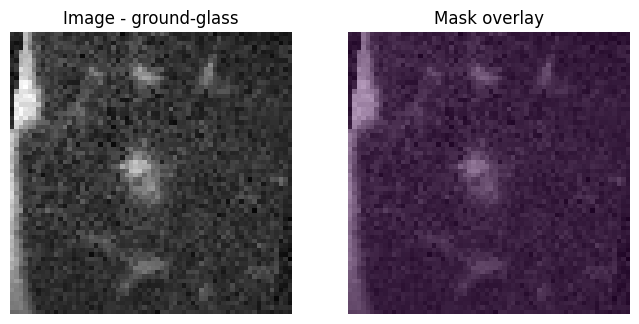


Sample 2: ground-glass
Image: ../dataset/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603_aug_0594.nii.gz
Mask:  ../dataset/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603_aug_0594_mask.nii.gz


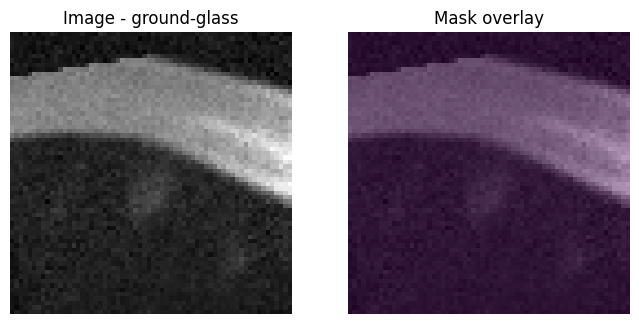


Sample 3: ground-glass
Image: ../dataset/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.277452631455527999380186898011_aug_0699.nii.gz
Mask:  ../dataset/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.277452631455527999380186898011_aug_0699_mask.nii.gz


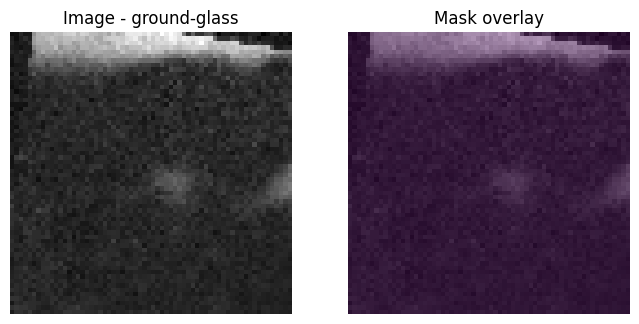


Sample 4: part-solid
Image: ../dataset/augmented/part-solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.346115813056769250958550383763_aug_0722.nii.gz
Mask:  ../dataset/augmented/part-solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.346115813056769250958550383763_aug_0722_mask.nii.gz


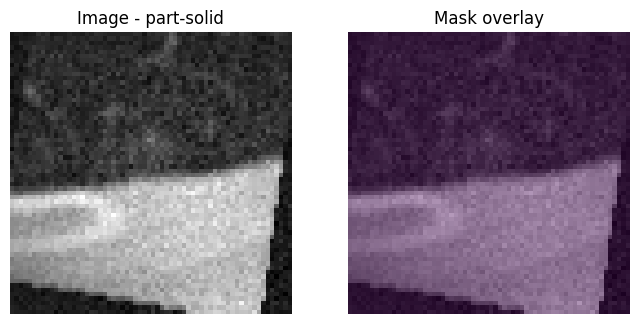


Sample 5: ground-glass
Image: ../dataset/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.264251211689085893915477907261_aug_0081.nii.gz
Mask:  ../dataset/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.264251211689085893915477907261_aug_0081_mask.nii.gz


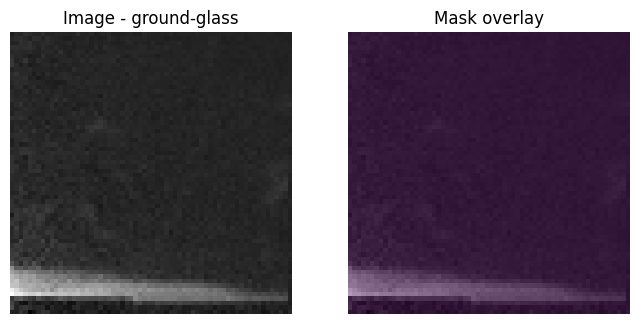

In [35]:
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

AUG_DIR = "../dataset/augmented"
classes = ["ground-glass", "part-solid", "solid"]

# Collect all augmented sample paths
all_images = []
for cls in classes:
    class_dir = os.path.join(AUG_DIR, cls)
    for fname in os.listdir(class_dir):
        if fname.endswith(".nii.gz") and "_mask" not in fname and "_aug_" in fname:
            img_path = os.path.join(class_dir, fname)
            mask_path = img_path.replace(".nii.gz", "_mask.nii.gz")
            all_images.append((cls, img_path, mask_path))

print(f"Total augmented images found: {len(all_images)}")

# Pick 5 random images
samples = random.sample(all_images, 5)

for i, (cls, img_path, mask_path) in enumerate(samples):
    print(f"\nSample {i+1}: {cls}")
    print("Image:", img_path)
    print("Mask: ", mask_path)

    # Load volumes
    img = nib.load(img_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()

    # Select central slice
    z = img.shape[2] // 2
    
    img_slice = img[:, :, z]
    mask_slice = mask[:, :, z]

    # Plot
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"Image - {cls}")
    plt.imshow(img_slice, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Mask overlay")
    plt.imshow(img_slice, cmap='gray')
    plt.imshow(mask_slice, alpha=0.4)   # overlay
    plt.axis('off')

    plt.show()
